<a href="https://colab.research.google.com/github/sgoff83/Audio-to-EEG-ML-model/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install gdown #downloads a public file/folder from Google Drive
!pip install librosa #python package for music and audio analysis
!pip install pyloudnorm #for normalization


In [12]:
import librosa
from scipy.signal import butter, filtfilt  #filtering
import numpy as np
import os
import matplotlib.pyplot as plt

In [13]:
# RESAMPLING
def resample_audio(audio_path, target_sr=16000):
    y, sr = librosa.load(str(audio_path), sr=target_sr)
    return y, sr




In [14]:
#FILTERING
def butter_lowpass_filter(y, cutoff_freq, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, y)
    #print(f"Filtered audio shape: {filtered_data.shape}")
    return filtered_data



In [15]:
#Normalization
import soundfile as sf
import pyloudnorm as pyln

def normalize(y, sr):
  peak_normalized_audio = pyln.normalize.peak(y, -1.0)
  meter = pyln.Meter(sr) #measures initial loudness
  loudness = meter.integrated_loudness(y)
  loudness_normalized_audio = pyln.normalize.loudness(y, loudness, -12.0)
  return loudness_normalized_audio

In [41]:
#a time-frequency representation of an audio signal

def compute_logmel_spectrogram(audio_path, n_mels=128, hop_length=512):
    y, sr = librosa.load(str(audio_path), sr=target_sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return logmel_spectrogram


target_sr = 16000




In [ ]:
import librosa
import soundfile as sf

def trim_audio(y, sr):
  y_trimmed = y[int(sr * 1):]
  # Return y_trimmed and sr
  return y_trimmed, sr

In [17]:
pip install --upgrade https://github.com/mne-tools/mne-python/archive/refs/heads/main.zip

  Using cached https://github.com/mne-tools/mne-python/archive/refs/heads/main.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [18]:
event_id = {
    'S01': 1,
    'S02': 2,
    'S03': 3,
    'S04': 4,
    'S11': 11,
    'S12': 12,
    'S13': 13,
    'S14': 14,
    'S21': 21,
    'S22': 22,
    'S23': 23,
    'S24': 24
}

In [19]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path

eeg_base_path = Path("/content/drive/MyDrive/Capstone EEGs/OpenMIIR/v1")

def load_eeg_epochs(eeg_base_path, pattern="P*-raw.fif", tmin=0.0, tmax=3.0, stim_channel='STI 014'):
    """
    Load EEG data from .fif files, extract epochs for each stimulus, and return signals organized by subject and stimulus.
    """
    all_epochs = {}
    metadata = []

    for eeg_file in eeg_base_path.glob(pattern):
        try:
            print(f"Processing {eeg_file.name}...")
            raw = mne.io.read_raw_fif(str(eeg_file), preload=True)
            raw.filter(1., 40., fir_design='firwin')  #band-pass filter for cleaner signals

            #extract events from stimulus channel
            events = mne.find_events(raw, stim_channel=stim_channel, verbose=False)

            print(f"Found {len(events)} events in {eeg_file.name}. Unique event IDs: {np.unique(events[:, 2])}")


            #generate event_id dictionary
            unique_event_ids = np.unique(events[:, 2])
            stim_condition = {str(id): int(id) for id in unique_event_ids if str(id)[-1] == '1'}

            if not stim_condition:
              print(f"No condition 1 events found for {eeg_file.name}")
              continue  # Skip this file if no condition 1 events




            #create epochs (trials) for all event types
            epochs = mne.Epochs(raw, events, event_id=stim_condition, tmin=tmin, tmax=tmax, preload=True, baseline=None)

            subject_id = eeg_file.stem.split('-')[0]
            all_epochs[subject_id] = {}

            for label in stim_condition.keys():
                label_epochs = epochs[label].get_data()  # shape: (n_trials, n_channels, n_times)
                all_epochs[subject_id][label] = label_epochs

                metadata.append({
                    'subject_id': subject_id,
                    'stimulus + condition': label,
                    'n_trials': label_epochs.shape[0],
                    'n_channels': label_epochs.shape[1],
                    'n_times': label_epochs.shape[2],
                    'sfreq': raw.info['sfreq']
                })

        except Exception as e:
            print(f"Error processing {eeg_file.name}: {e}")

    metadata_df = pd.DataFrame(metadata)
    return metadata_df, all_epochs
metadata_df, all_epochs = load_eeg_epochs(eeg_base_path)
print(metadata_df.head())

Processing P01-raw.fif...
Opening raw data file /content/drive/MyDrive/Capstone EEGs/OpenMIIR/v1/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)

Found 540 events in P01-raw.fif. Unique event IDs: [  11   12   13   14   21   22   23   24   31   3

In [ ]:
print(metadata_df.shape)

(140, 6)


In [ ]:
print(metadata_df.head(50))

   subject_id stimulus + condition  n_trials  n_channels  n_times  sfreq
0         P01                   11         5          69     1537  512.0
1         P01                   21         5          69     1537  512.0
2         P01                   31         5          69     1537  512.0
3         P01                   41         5          69     1537  512.0
4         P01                  111         5          69     1537  512.0
5         P01                  121         5          69     1537  512.0
6         P01                  131         5          69     1537  512.0
7         P01                  141         5          69     1537  512.0
8         P01                  211         5          69     1537  512.0
9         P01                  221         5          69     1537  512.0
10        P01                  231         5          69     1537  512.0
11        P01                  241         5          69     1537  512.0
12        P01                 1111        60       

In [40]:
#Preprocessing and putting audio in Dataframe


import mne
import pandas as pd
from pathlib import Path
import librosa

base_path = Path("/content/drive/MyDrive/Capstone Audios/open MIIR/v2")




def preprocess_audio(base_path, pattern='*.wav'):
  audio_data = []
  udio_spectograms = []

  matching_files = list(base_path.glob(pattern))
  print(f"Found {len(matching_files)} .wav files")

  for audio_file in base_path.glob(pattern):
    try:
      y, sr = librosa.load(audio_file, sr=None)
      resampled_audio, resampled_sr = resample_audio(str(audio_file), target_sr=16000)
      filtered_audio = butter_lowpass_filter(resampled_audio, cutoff_freq=4000, sample_rate=sr)
      trimmed_audio = trim_audio(y,sr)
      normalized_audio = normalize(y,sr)
      logmel_spectrogram = compute_logmel_spectrogram(audio_file, sr)
      audio_dict = {
          'filename': audio_file.name,
          'y': y,
          'sr': sr,
          'stimulus': audio_file.stem,
          'filtered_audio': filtered_audio,
          'logmel_spectrogram': logmel_spectrogram,
          'normalized_audio': normalized_audio,
          'trimmed_audio': trimmed_audio
         }
      audio_data.append(audio_dict)
      audio_spectograms.append(logmel_spectrogram)
    except Exception as e:
      print(f"Error processing {audio_file}")

  audio_df = pd.DataFrame(audio_data)
  audio_df['audio_stimulus'] = audio_df['stimulus'].apply(lambda x: x.split('_')[0])

  return audio_df



audio_df = preprocess_audio(base_path)
print(audio_df.head())







Found 12 .wav files


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S12_Take Me Out To The Ballgame_no lyrics.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S01_Chim Chim Cheree_lyrics.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S14_Mary Had A Little Lamb_no lyrics.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S04_Mary Had A Little Lamb_lyrics.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S23_Star Wars Theme.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S03_Jingle Bells_lyrics.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S21_EmperorWaltz.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S02_Take Me Out To The Ballgame_lyrics.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S13_Jingle Bells_no lyrics.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S11_Chim Chim Cheree_no lyrics.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S22_Harry Potter Theme.wav


/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Error processing /content/drive/MyDrive/Capstone Audios/open MIIR/v2/S24_Eine kleine Nachtmusic.wav
                                        filename  \
0  S12_Take Me Out To The Ballgame_no lyrics.wav   
1                S01_Chim Chim Cheree_lyrics.wav   
2       S14_Mary Had A Little Lamb_no lyrics.wav   
3          S04_Mary Had A Little Lamb_lyrics.wav   
4                        S23_Star Wars Theme.wav   

                                                   y     sr  \
0  [3.0517578e-05, 0.0879364, 0.34191895, 0.48889...  44100   
1  [0.0, 0.08792114, 0.3419037, 0.48893738, 0.608...  44100   
2  [3.0517578e-05, 0.0879364, 0.34187317, 0.48890...  44100   
3  [1.5258789e-05, 0.0879364, 0.34188843, 0.48892...  44100   
4  [-3.0517578e-05, 0.0879364, 0.34196472, 0.4889...  44100   

                                    stimulus  \
0  S12_Take Me Out To The Ballgame_no lyrics   
1                S01_Chim Chim Cheree_lyrics   
2       S14_Mary Had A Little Lamb_no lyrics   
3          S04_M

In [21]:
def map_eeg_to_audio(stimulus):
    if stimulus in ['11', '12', '13', '14']:
        return 'S01'
    elif stimulus in ['21', '22', '23', '24']:
        return 'S02'
    elif stimulus in ['31', '32', '33', '34']:
        return 'S03'
    elif stimulus in ['41', '42', '43', '44']:
        return 'S04'
    elif stimulus in ['111', '112', '113', '114']:
        return 'S11'
    elif stimulus in ['121', '122', '123', '124']:
        return 'S12'
    elif stimulus in ['131', '132', '133', '134']:
        return 'S13'
    elif stimulus in ['141', '142', '143', '144']:
        return 'S14'
    elif stimulus in ['211', '212', '213', '214']:
        return 'S21'
    elif stimulus in ['221', '222', '223', '224']:
        return 'S22'
    elif stimulus in ['231', '232', '233', '234']:
        return 'S23'
    elif stimulus in ['241', '242', '243', '244']:
        return 'S24'
    else:
        return None


metadata_df['audio_stimulus'] = metadata_df['stimulus + condition'].apply(map_eeg_to_audio)


print(metadata_df[['stimulus + condition', 'audio_stimulus']].drop_duplicates())


   stimulus + condition audio_stimulus
0                    11            S01
1                    21            S02
2                    31            S03
3                    41            S04
4                   111            S11
5                   121            S12
6                   131            S13
7                   141            S14
8                   211            S21
9                   221            S22
10                  231            S23
11                  241            S24
12                 1111           None
13                 2001           None


In [ ]:
print(metadata_df.columns)
print(audio_df.columns)

Index(['subject_id', 'stimulus + condition', 'n_trials', 'n_channels',
       'n_times', 'sfreq', 'audio_stimulus'],
      dtype='object')
Index(['filename', 'y', 'sr', 'stimulus', 'filtered_audio',
       'logmel_spectrogram', 'normalized_audio', 'trimmed_audio',
       'audio_stimulus'],
      dtype='object')


In [22]:

audio_df.rename(columns={'stimulus': 'stimulus_audio'}, inplace=True)
merged_df = pd.merge(metadata_df, audio_df, on='audio_stimulus', how='left')
merged_df.drop(columns=['stimulus_audio'], inplace=True)
merged_df.dropna(subset=['stimulus + condition', 'audio_stimulus'], inplace=True)
print(merged_df[['stimulus + condition', 'audio_stimulus', 'filename', 'logmel_spectrogram']])



    stimulus + condition audio_stimulus  \
0                     11            S01   
1                     21            S02   
2                     31            S03   
3                     41            S04   
4                    111            S11   
..                   ...            ...   
133                  141            S14   
134                  211            S21   
135                  221            S22   
136                  231            S23   
137                  241            S24   

                                       filename  \
0               S01_Chim Chim Cheree_lyrics.wav   
1    S02_Take Me Out To The Ballgame_lyrics.wav   
2                   S03_Jingle Bells_lyrics.wav   
3         S04_Mary Had A Little Lamb_lyrics.wav   
4            S11_Chim Chim Cheree_no lyrics.wav   
..                                          ...   
133    S14_Mary Had A Little Lamb_no lyrics.wav   
134                        S21_EmperorWaltz.wav   
135                  S22

In [ ]:
print(merged_df.head())

  subject_id stimulus + condition  n_trials  n_channels  n_times  sfreq  \
0        P01                   11         5          69     1537  512.0   
1        P01                   21         5          69     1537  512.0   
2        P01                   31         5          69     1537  512.0   
3        P01                   41         5          69     1537  512.0   
4        P01                  111         5          69     1537  512.0   

  audio_stimulus                                    filename  \
0            S01             S01_Chim Chim Cheree_lyrics.wav   
1            S02  S02_Take Me Out To The Ballgame_lyrics.wav   
2            S03                 S03_Jingle Bells_lyrics.wav   
3            S04       S04_Mary Had A Little Lamb_lyrics.wav   
4            S11          S11_Chim Chim Cheree_no lyrics.wav   

                                                   y       sr  \
0  [0.0, 0.08792114, 0.3419037, 0.48893738, 0.608...  44100.0   
1  [1.5258789e-05, 0.08792114, 0.3

In [ ]:
print(set(stimulus_key for subject_data in all_epochs.values() for stimulus_key in subject_data.keys()))

{'131', '231', '2001', '41', '141', '31', '241', '221', '11', '121', '211', '111', '21', '1111'}


In [ ]:
print(audio_df['audio_stimulus'].unique())

['S12' 'S01' 'S14' 'S04' 'S23' 'S03' 'S21' 'S02' 'S13' 'S11' 'S22' 'S24']


In [23]:

audio_lookup = {}
for stimulus in audio_df['audio_stimulus'].unique():
    matching_rows = audio_df[audio_df['audio_stimulus'] == stimulus]
    if not matching_rows.empty:
        audio_lookup[stimulus] = matching_rows['filename'].iloc[0]


matched_trials = []

for subject_id, subject_data in all_epochs.items():
    for stimulus_key, trials in subject_data.items():
        audio_stimulus_key = map_eeg_to_audio(stimulus_key)

        if audio_stimulus_key is None:
            print(f"Warning: No mapping found for {stimulus_key}")
            continue

        audio_filename = audio_lookup.get(audio_stimulus_key)

        if audio_filename is None:
            print(f"Warning: No audio file found for {audio_stimulus_key}")
            continue
        for trial in trials:
            matched_trials.append({
                'audio_stimulus': audio_filename,
                'subject_id': subject_id,
                'stimulus': stimulus_key,
                'stimulus + condition': f"{stimulus_key}_condition",
                'eeg_trial': trial
            })

print(f"Total matched trials: {len(matched_trials)}")
matched_df = pd.DataFrame(matched_trials)


print(matched_df.head(30))

Total matched trials: 600
                                   audio_stimulus subject_id stimulus  \
0                 S01_Chim Chim Cheree_lyrics.wav        P01       11   
1                 S01_Chim Chim Cheree_lyrics.wav        P01       11   
2                 S01_Chim Chim Cheree_lyrics.wav        P01       11   
3                 S01_Chim Chim Cheree_lyrics.wav        P01       11   
4                 S01_Chim Chim Cheree_lyrics.wav        P01       11   
5      S02_Take Me Out To The Ballgame_lyrics.wav        P01       21   
6      S02_Take Me Out To The Ballgame_lyrics.wav        P01       21   
7      S02_Take Me Out To The Ballgame_lyrics.wav        P01       21   
8      S02_Take Me Out To The Ballgame_lyrics.wav        P01       21   
9      S02_Take Me Out To The Ballgame_lyrics.wav        P01       21   
10                    S03_Jingle Bells_lyrics.wav        P01       31   
11                    S03_Jingle Bells_lyrics.wav        P01       31   
12                    S03

In [24]:
pip install --upgrade gradio

In [ ]:
print(matched_df.head())

                    audio_stimulus subject_id stimulus stimulus + condition  \
0  S01_Chim Chim Cheree_lyrics.wav        P01       11         11_condition   
1  S01_Chim Chim Cheree_lyrics.wav        P01       11         11_condition   
2  S01_Chim Chim Cheree_lyrics.wav        P01       11         11_condition   
3  S01_Chim Chim Cheree_lyrics.wav        P01       11         11_condition   
4  S01_Chim Chim Cheree_lyrics.wav        P01       11         11_condition   

                                           eeg_trial  
0  [[-4.192596076347012e-06, -2.9754692429104204e...  
1  [[1.590882909663292e-05, 1.3772193555163568e-0...  
2  [[1.0042037075888488e-05, 1.0188784834020433e-...  
3  [[-1.8705634064414164e-05, -1.9799000642351977...  
4  [[-2.3870998302486057e-05, -2.44638518936264e-...  


In [ ]:
print(audio_df.head())

                                        filename  \
0  S12_Take Me Out To The Ballgame_no lyrics.wav   
1                S01_Chim Chim Cheree_lyrics.wav   
2       S14_Mary Had A Little Lamb_no lyrics.wav   
3          S04_Mary Had A Little Lamb_lyrics.wav   
4                        S23_Star Wars Theme.wav   

                                                   y     sr  \
0  [3.0517578e-05, 0.0879364, 0.34191895, 0.48889...  44100   
1  [0.0, 0.08792114, 0.3419037, 0.48893738, 0.608...  44100   
2  [3.0517578e-05, 0.0879364, 0.34187317, 0.48890...  44100   
3  [1.5258789e-05, 0.0879364, 0.34188843, 0.48892...  44100   
4  [-3.0517578e-05, 0.0879364, 0.34196472, 0.4889...  44100   

                              stimulus_audio  \
0  S12_Take Me Out To The Ballgame_no lyrics   
1                S01_Chim Chim Cheree_lyrics   
2       S14_Mary Had A Little Lamb_no lyrics   
3          S04_Mary Had A Little Lamb_lyrics   
4                        S23_Star Wars Theme   

                   

After downsampling: max_time_steps=11025, freq_bins=143
EEG output dimensions: 69 channels, 385 time points (downsampled from 1537)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11025, 143, 8)  │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5512, 71, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5512, 71, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2756, 35, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1378, 17, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 374816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │    11,994,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26565)          │       876,645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 69, 385)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,872,037 (49.10 MB)

 Trainable params: 12,872,037 (49.10 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
Epoch 1/3
Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
 1/24 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - loss: 39.6551 - mae: 0.0576Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
 2/24 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 34.6980 - mae: 0.2463 Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
Shape of log_spectrogram: (11025, 143)
Shape of eeg_trial: (69, 385)
 3/24 ━━━━━━━━━━━━━━━━━━

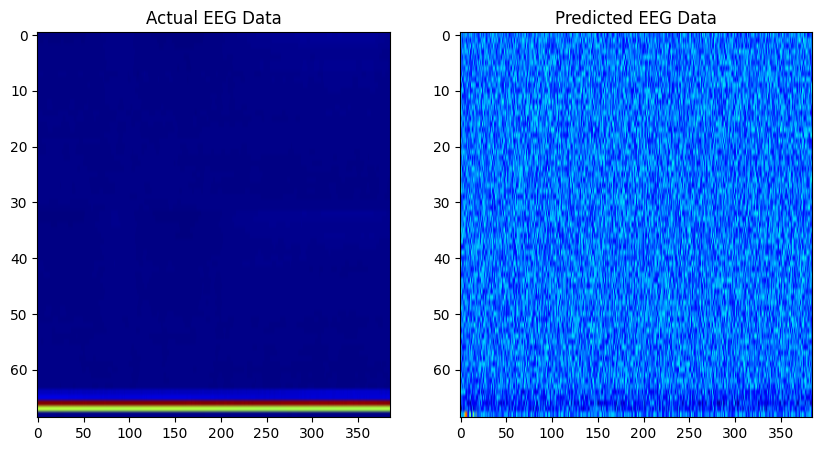

Model saved successfully!


In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam


def downsample_spectrogram(spectrogram, factor=4):
    """Downsample spectrogram by taking every nth point"""
    if factor <= 1:
        return spectrogram
    return spectrogram[::factor, ::factor]

#sample 10% of the data
matched_df_sampled = matched_df.sample(frac=0.1, random_state=42)

#reduce dimensions
downsample_factor = 4
downsample_factor_eeg = 4


freq_bins = 0
max_time_steps = 0
for _, row in audio_df.iterrows():
    log_spectrogram = np.array(row['logmel_spectrogram'])
    log_spectrogram = downsample_spectrogram(log_spectrogram, factor=downsample_factor)
    max_time_steps = max(max_time_steps, log_spectrogram.shape[0])
    freq_bins = max(freq_bins, log_spectrogram.shape[1])

print(f"After downsampling: max_time_steps={max_time_steps}, freq_bins={freq_bins}")

#reduceD EEG output dimensions
n_channels = 69
n_times_original = 1537
downsample_factor_eeg = 4
n_times = 385

print(f"EEG output dimensions: {n_channels} channels, {n_times} time points (downsampled from {n_times_original})")

#custom data generator with memory optimization
class EEGLogMelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, audio_dataframe, batch_size, max_time_steps, freq_bins, downsample_factor=4, downsample_factor_eeg=4, shuffle=True):
        self.dataframe = dataframe
        self.audio_df = audio_dataframe
        self.batch_size = batch_size
        self.max_time_steps = max_time_steps
        self.freq_bins = freq_bins
        self.downsample_factor = downsample_factor
        self.downsample_factor_eeg = downsample_factor_eeg
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indexes]

        X_batch = []
        y_batch = []

        for _, row in batch_data.iterrows():
            try:
                if 'audio_stimulus' not in row:
                    print(f"Missing 'audio_stimulus' column. Available columns: {row.index.tolist()}")
                    continue

                if 'eeg_trial' not in row:
                    print(f"Missing 'eeg_trial' column. Available columns: {row.index.tolist()}")
                    continue



                full_audio_key = row['audio_stimulus']
                if isinstance(full_audio_key, str) and '_' in full_audio_key:
                    subject_id = full_audio_key.split('_')[0]
                else:
                    subject_id = str(full_audio_key)


                eeg_trial = np.array(row['eeg_trial'])

                #ensure EEG trial consistency (n_channels = 69)
                expected_n_channels = 69
                if eeg_trial.shape[0] < expected_n_channels:
                  pad_width = expected_n_channels - eeg_trial.shape[0]
                  eeg_trial = np.pad(eeg_trial, ((0, pad_width), (0, 0)), mode='constant')
                elif eeg_trial.shape[0] > expected_n_channels:
                  eeg_trial = eeg_trial[:expected_n_channels, :]

            #downsample EEG trial
                expected_n_times = 385
                current_n_times = eeg_trial.shape[1]
                if current_n_times < expected_n_times:
                  pad_width = expected_n_times - current_n_times
                  eeg_trial = np.pad(eeg_trial, ((0, 0), (0, pad_width)), mode='constant')
                elif current_n_times > expected_n_times:
                  eeg_trial = eeg_trial[:, :expected_n_times]

                matching_rows = self.audio_df[self.audio_df['audio_stimulus'] == subject_id]


                if matching_rows.empty:
                  matching_rows = self.audio_df[self.audio_df['stimulus_audio'].str.startswith(subject_id)]


                if matching_rows.empty and 'filename' in self.audio_df.columns:
                  matching_rows = self.audio_df[self.audio_df['filename'] == full_audio_key]


                if matching_rows.empty:
                  print(f"No matching audio found for key: {full_audio_key} (subject_id: {subject_id})")
                  continue



                log_spectrogram = np.array(matching_rows['logmel_spectrogram'].values[0])

                #downsample spectrogram
                log_spectrogram = downsample_spectrogram(log_spectrogram, factor=self.downsample_factor)


                current_steps = log_spectrogram.shape[0]
                current_bins = log_spectrogram.shape[1]

                #handle time dimension
                if current_steps < self.max_time_steps:
                    pad_width = self.max_time_steps - current_steps
                    log_spectrogram = np.pad(
                        log_spectrogram, ((0, pad_width), (0, 0)), mode='constant'
                    )
                elif current_steps > self.max_time_steps:
                    log_spectrogram = log_spectrogram[:self.max_time_steps, :]

               #frequency
                if current_bins < self.freq_bins:
                    pad_width = self.freq_bins - current_bins
                    log_spectrogram = np.pad(
                        log_spectrogram, ((0, 0), (0, pad_width)), mode='constant'
                    )
                elif current_bins > self.freq_bins:
                    log_spectrogram = log_spectrogram[:, :self.freq_bins]

                print(f"Shape of log_spectrogram: {log_spectrogram.shape}")
                print(f"Shape of eeg_trial: {eeg_trial.shape}")

                X_batch.append(log_spectrogram)
                y_batch.append(eeg_trial)
            except Exception as e:
                print(f"Error processing sample: {e}")
                continue

        if len(X_batch) == 0:
            empty_X = np.zeros((0, self.max_time_steps, self.freq_bins, 1))
            empty_y = np.zeros((0, n_channels, n_times))
            return empty_X, empty_y

        X_batch = np.array(X_batch)[..., np.newaxis]
        y_batch = np.array(y_batch)

        expected_n_times = 385
        for i in range(len(y_batch)):
          current_shape = y_batch[i].shape
          if current_shape[1] != expected_n_times:
            if current_shape[1] < expected_n_times:
                pad_width = expected_n_times - current_shape[1]
                y_batch[i] = np.pad(
                    y_batch[i], ((0, 0), (0, pad_width)), mode='constant'
                )
            else:
                y_batch[i] = y_batch[i][:, :expected_n_times]

        mean_val = np.mean(X_batch)
        std_val = np.std(X_batch)
        if std_val > 0:
            X_batch = (X_batch - mean_val) / std_val

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

#small batch size to reduce memory usage
batch_size = 2

# split data
train_df = matched_df_sampled.sample(frac=0.8, random_state=42)
val_df = matched_df_sampled.drop(train_df.index)

#generators with smaller batch size and downsampling
train_gen = EEGLogMelDataGenerator(
    train_df,
    batch_size=batch_size,
    audio_dataframe = audio_df,
    max_time_steps=max_time_steps,
    freq_bins=freq_bins,
    downsample_factor=downsample_factor,
    downsample_factor_eeg=downsample_factor_eeg,
    shuffle=True
)

val_gen = EEGLogMelDataGenerator(
    val_df,
     audio_dataframe=audio_df,
    batch_size=batch_size,
    max_time_steps=max_time_steps,
    freq_bins=freq_bins,
    downsample_factor=downsample_factor,
    downsample_factor_eeg=downsample_factor_eeg,
    shuffle=False
)


model = Sequential([
    Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(max_time_steps, freq_bins, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(n_channels * n_times, activation='linear'),
    Reshape((n_channels, n_times))
])


optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mae']
)


model.summary()


try:
    history = model.fit(
        train_gen,
        epochs=3,
        validation_data=val_gen,
        verbose=1,
    )

    #EVALUATE
    loss, mae = model.evaluate(val_gen)
    print(f"Test Mean Absolute Error: {mae:.2f}")

    #make predictions on a single sample to save memory
    for x_test, y_test in val_gen:
        if len(x_test) > 0:
            single_sample = x_test[0:1]
            y_pred = model.predict(single_sample)

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.title("Actual EEG Data")
            plt.imshow(y_test[0], cmap='jet', aspect='auto')

            plt.subplot(1, 2, 2)
            plt.title("Predicted EEG Data")
            plt.imshow(y_pred[0], cmap='jet', aspect='auto')

            plt.show()
            break


    model.save('eeg_model_ram_efficient.h5')
    print("Model saved successfully!")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

In [26]:
import os


if os.path.exists('eeg_model_ram_efficient.h5'):
    print("Model file found!")
else:
    print("Model file not found.")

print("Files in the current directory:")
for filename in os.listdir():
    print(filename)

Model file found!
Files in the current directory:
.config
eeg_model_ram_efficient.h5
.gradio
drive
sample_data


In [7]:

!pip install gradio
!pip install --upgrade gradio
import gradio as gr
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from scipy.signal import butter, filtfilt
import mne

#TODO - fix UI.

#def downsample_spectrogram(spectrogram, factor=4):
    #if factor <= 1:
        #return spectrogram
    #return spectrogram[::factor, ::factor]

#def preprocess_single_audio(audio_file_path, downsample_factor=4):
    #try:
        #y, sr = resample_audio(audio_file_path, target_sr=16000)
        #filtered_audio = butter_lowpass_filter(y, cutoff_freq=4000, sample_rate=sr, order=4)
        #trimmed_audio = trim_audio(filtered_audio)
        #normalized_audio = normalize(trimmed_audio, sr)
        #logmel_spectrogram = compute_logmel_spectrogram(normalized_audio, sr, n_mels=128, hop_length=512)
        #downsampled_spectrogram = downsample_spectrogram(logmel_spectrogram, factor=downsample_factor)

        #return {
            #'filename': pathlib.Path(audio_file_path).name,
            #'stimulus': pathlib.Path(audio_file_path).stem,
            #'y': y,
            #'sr': sr,
            #'filtered_audio': filtered_audio,
            #'trimmed_audio': trimmed_audio,
            #'normalized_audio': normalized_audio,
            #'logmel_spectrogram': logmel_spectrogram,
            #'downsampled_spectrogram': downsampled_spectrogram
        #}
    #except Exception as e:
        #print(f"Error processing {audio_file_path}: {e}")
        #raise e

#global model variable
#model = None

#def load_model(model_path='eeg_model_ram_efficient.h5'):
    #global model
    #if model is None:
        #try:
            #model = tf.keras.models.load_model(model_path)
            #print(f"Model loaded successfully. Input shape: {model.input_shape}, Output shape: {model.output_shape}")
        #except Exception as e:
            #print(f"Error loading model: {e}")
            #raise e
    #return model

#def prepare_spectrogram_for_model(spectrogram, expected_shape):
    #extract expected dimensions from model input shape
    #model expects (batch_size, max_time_steps, freq_bins, 1)
    #expected_time_steps = expected_shape[1]
    #expected_freq_bins = expected_shape[2]

    #current dimensions
    #current_steps = spectrogram.shape[0]
    #current_bins = spectrogram.shape[1]

    #print(f"Current spectrogram shape: {spectrogram.shape}")
    #print(f"Expected dimensions: time_steps={expected_time_steps}, freq_bins={expected_freq_bins}")

    #handle time dimension
    #if current_steps < expected_time_steps:
        #pad_width = expected_time_steps - current_steps
        #spectrogram = np.pad(spectrogram, ((0, pad_width), (0, 0)), mode='constant')
    #elif current_steps > expected_time_steps:
        #spectrogram = spectrogram[:expected_time_steps, :]

    #handle frequency dimension
    #if current_bins < expected_freq_bins:
        #pad_width = expected_freq_bins - current_bins
        #spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    #elif current_bins > expected_freq_bins:
        #spectrogram = spectrogram[:, :expected_freq_bins]

    #print(f"Adjusted spectrogram shape: {spectrogram.shape}")

    #add batch and channel dimensions as expected by the model
    #spectrogram = np.expand_dims(spectrogram, axis=0)  #batch dimension
    #spectrogram = np.expand_dims(spectrogram, axis=-1)  #channel dimension

    #normalize input
    #mean_val = np.mean(spectrogram)
    #std_val = np.std(spectrogram)
    #if std_val > 0:
        #spectrogram = (spectrogram - mean_val) / std_val

    #print(f"Final input shape: {spectrogram.shape}")
    #return spectrogram

#def plot_eeg_channels(eeg_data, filename, sample_rate=128):
    #ensure eeg_data has the correct shape (69, 385)
    #if len(eeg_data.shape) == 3 and eeg_data.shape[0] == 1:
        #eeg_data = eeg_data[0]

    #print(f"EEG data shape for plotting: {eeg_data.shape}")

    #n_channels = eeg_data.shape[0]
    #n_times = eeg_data.shape[1]


    #fig = plt.figure(figsize=(12, 8))
    #num_channels_to_plot = min(15, n_channels)
    #times = np.linspace(0, n_times / sample_rate, n_times)
    #colors = plt.cm.viridis(np.linspace(0, 1, num_channels_to_plot))
    #offset_factor = 20e-6  # visibility
    #for i in range(num_channels_to_plot):
        #plt.plot(times, eeg_data[i] + (i * offset_factor),
                 #label=f'Ch {i+1}',
                 #color=colors[i],
                 #linewidth=1.5)

    #plt.title(f'Predicted EEG for {filename}', fontsize=16)
    #plt.xlabel('Time (s)', fontsize=14)
    #plt.ylabel('Amplitude (μV)', fontsize=14)
    #plt.grid(True, alpha=0.3)
    #plt.legend(loc='upper right', fontsize=10)
    #plt.tight_layout()

    #return fig

#def predict_eeg(audio_file):
    #if audio_file is None:
        #return "Please upload an audio file."

    #if not isinstance(audio_file, str) or not audio_file.lower().endswith('.wav'):
        #return "Please upload a .wav file."

    #try:
        #print(f"Processing audio file: {audio_file}")
        #processed_audio = preprocess_single_audio(audio_file, downsample_factor=4)
        #model = load_model()
        #input_data = prepare_spectrogram_for_model(
        #    processed_audio['downsampled_spectrogram'],
        #    model.input_shape
        #)
        #print("Running inference...")
        #predicted_eeg = model.predict(input_data)
        #predicted_eeg = predicted_eeg.squeeze(0);
        #print(f"Prediction successful. Output shape: {predicted_eeg.shape}")

        #debugging
        #if len(predicted_eeg.shape) == 3:
            #print(f"First dimension (batch) size: {predicted_eeg.shape[0]}")
            #print(f"Number of channels: {predicted_eeg.shape[1]}")
            #print(f"Time points: {predicted_eeg.shape[2]}")

        #filename = pathlib.Path(audio_file).name
        #fig = plot_eeg_channels(predicted_eeg, filename)

        #return fig

    #except Exception as e:
        #import traceback
        #error_details = traceback.format_exc()
        #print(f"Error processing: {str(e)}\n{error_details}")
        #return f"Error processing: {str(e)}. Check console for details."



#TODO - fix UI.

#def downsample_spectrogram(spectrogram, factor=4):
    #if factor <= 1:
        #return spectrogram
    #return spectrogram[::factor, ::factor]

#def preprocess_single_audio(audio_file_path, downsample_factor=4):
    #try:
        #y, sr = resample_audio(audio_file_path, target_sr=16000)
        #filtered_audio = butter_lowpass_filter(y, cutoff_freq=4000, sample_rate=sr, order=4)
        #trimmed_audio = trim_audio(filtered_audio)
        #normalized_audio = normalize(trimmed_audio, sr)
        #logmel_spectrogram = compute_logmel_spectrogram(normalized_audio, sr, n_mels=128, hop_length=512)
        #downsampled_spectrogram = downsample_spectrogram(logmel_spectrogram, factor=downsample_factor)

        #return {
            #'filename': pathlib.Path(audio_file_path).name,
            #'stimulus': pathlib.Path(audio_file_path).stem,
            #'y': y,
            #'sr': sr,
            #'filtered_audio': filtered_audio,
            #'trimmed_audio': trimmed_audio,
            #'normalized_audio': normalized_audio,
            #'logmel_spectrogram': logmel_spectrogram,
            #'downsampled_spectrogram': downsampled_spectrogram
        #}
    #except Exception as e:
        #print(f"Error processing {audio_file_path}: {e}")
        #raise e

#global model variable
#model = None

#def load_model(model_path='eeg_model_ram_efficient.h5'):
    #global model
    #if model is None:
        #try:
            #model = tf.keras.models.load_model(model_path)
            #print(f"Model loaded successfully. Input shape: {model.input_shape}, Output shape: {model.output_shape}")
        #except Exception as e:
            #print(f"Error loading model: {e}")
            #raise e
    #return model

#def prepare_spectrogram_for_model(spectrogram, expected_shape):
    #extract expected dimensions from model input shape
    #model expects (batch_size, max_time_steps, freq_bins, 1)
    #expected_time_steps = expected_shape[1]
    #expected_freq_bins = expected_shape[2]

    #current dimensions
    #current_steps = spectrogram.shape[0]
    #current_bins = spectrogram.shape[1]

    #print(f"Current spectrogram shape: {spectrogram.shape}")
    #print(f"Expected dimensions: time_steps={expected_time_steps}, freq_bins={expected_freq_bins}")

    #handle time dimension
    #if current_steps < expected_time_steps:
        #pad_width = expected_time_steps - current_steps
        #spectrogram = np.pad(spectrogram, ((0, pad_width), (0, 0)), mode='constant')
    #elif current_steps > expected_time_steps:
        #spectrogram = spectrogram[:expected_time_steps, :]

    #handle frequency dimension
    #if current_bins < expected_freq_bins:
        #pad_width = expected_freq_bins - current_bins
        #spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    #elif current_bins > expected_freq_bins:
        #spectrogram = spectrogram[:, :expected_freq_bins]

    #print(f"Adjusted spectrogram shape: {spectrogram.shape}")

    #add batch and channel dimensions as expected by the model
    #spectrogram = np.expand_dims(spectrogram, axis=0)  #batch dimension
    #spectrogram = np.expand_dims(spectrogram, axis=-1)  #channel dimension

    #normalize input
    #mean_val = np.mean(spectrogram)
    #std_val = np.std(spectrogram)
    #if std_val > 0:
        #spectrogram = (spectrogram - mean_val) / std_val

    #print(f"Final input shape: {spectrogram.shape}")
    #return spectrogram

#def plot_eeg_channels(eeg_data, filename, sample_rate=128):
    #ensure eeg_data has the correct shape (69, 385)
    #if len(eeg_data.shape) == 3 and eeg_data.shape[0] == 1:
        #eeg_data = eeg_data[0]

    #print(f"EEG data shape for plotting: {eeg_data.shape}")

    #n_channels = eeg_data.shape[0]
    #n_times = eeg_data.shape[1]


    #fig = plt.figure(figsize=(12, 8))
    #num_channels_to_plot = min(15, n_channels)
    #times = np.linspace(0, n_times / sample_rate, n_times)
    #colors = plt.cm.viridis(np.linspace(0, 1, num_channels_to_plot))
    #offset_factor = 20e-6  # visibility
    #for i in range(num_channels_to_plot):
        #plt.plot(times, eeg_data[i] + (i * offset_factor),
                 #label=f'Ch {i+1}',
                 #color=colors[i],
                 #linewidth=1.5)

    #plt.title(f'Predicted EEG for {filename}', fontsize=16)
    #plt.xlabel('Time (s)', fontsize=14)
    #plt.ylabel('Amplitude (μV)', fontsize=14)
    #plt.grid(True, alpha=0.3)
    #plt.legend(loc='upper right', fontsize=10)
    #plt.tight_layout()

    #return fig

#def predict_eeg(audio_file):
    #if audio_file is None:
        #return "Please upload an audio file."

    #if not isinstance(audio_file, str) or not audio_file.lower().endswith('.wav'):
        #return "Please upload a .wav file."

    #try:
        #print(f"Processing audio file: {audio_file}")
        #processed_audio = preprocess_single_audio(audio_file, downsample_factor=4)
        #model = load_model()
        #input_data = prepare_spectrogram_for_model(
        #    processed_audio['downsampled_spectrogram'],
        #    model.input_shape
        #)
        #print("Running inference...")
        #predicted_eeg = model.predict(input_data)
        #predicted_eeg = predicted_eeg.squeeze(0);
        #print(f"Prediction successful. Output shape: {predicted_eeg.shape}")

        #debugging
        #if len(predicted_eeg.shape) == 3:
            #print(f"First dimension (batch) size: {predicted_eeg.shape[0]}")
            #print(f"Number of channels: {predicted_eeg.shape[1]}")
            #print(f"Time points: {predicted_eeg.shape[2]}")

        #filename = pathlib.Path(audio_file).name
        #fig = plot_eeg_channels(predicted_eeg, filename)

        #return fig

    #except Exception as e:
        #import traceback
        #error_details = traceback.format_exc()
        #print(f"Error processing: {str(e)}\n{error_details}")
        #return f"Error processing: {str(e)}. Check console for details."


css = """
h1 {
    color: #000000;
    text-align: center;
    font-size: 2.5em;
}
.gradio-container {
    background-color: #000000;
    padding: 20px;
    border-radius: 10px;
    box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.1);
}
"""

eeg_file_path = "/content/drive/MyDrive/Capstone EEGs/OpenMIIR/v1/P01-raw.fif"
raw = mne.io.read_raw_fif(eeg_file_path, preload=True)

def predict_eeg(audio_file):
    if not audio_file.lower().endswith('.wav'):
        return "Please upload a .wav file."



    eeg_file_path = "/content/drive/MyDrive/Capstone EEGs/OpenMIIR/v1/P01-raw.fif"

    try:
        #load EEG data
        raw = mne.io.read_raw_fif(eeg_file_path, preload=True)

        #reate a plot figure for the EEG data
        fig = plt.figure(figsize=(12, 8))

        #extract data and times from the raw EEG data
        data = raw.get_data()
        times = raw.times

        end_idx = len(times)


        #specify duration to visualize
        sample_rate = raw.info['sfreq']
        plot_times = times[:end_idx]
        plot_data = data[:, :end_idx]

        #plot data from the first BLANK number of channels
        for i in range(20):  #plot first 20
            plt.plot(plot_times, plot_data[i] + (i * 20e-6), label=raw.ch_names[i])

        #titles and labels
        plt.title(f'EEG Time Series Data for {audio_file}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (µV)')
        plt.legend()
        plt.tight_layout()

        return fig

    except Exception as e:
        return f"Error loading EEG data: {e}"

demo = gr.Interface(
    fn=predict_eeg,
    inputs=gr.Audio(type="filepath", label="Upload Audio File (.wav)"),
    outputs=[
        gr.Plot(label="EEG Channel Visualization"),
    ],
    title="Audio to EEG Prediction",
    description="Upload a .wav audio file to predict the corresponding EEG signals.",
    css=css
)

#interface
if __name__ == "__main__":
    #load_model()
    demo.launch()

Opening raw data file /content/drive/MyDrive/Capstone EEGs/OpenMIIR/v1/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c72fe27da4caf9a3f3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

model = tf.keras.models.load_model('eeg_model_ram_efficient.h5')
